# Project 4

In this project, you will summarize and present your analysis from Projects 1-3.

### Part 1 - Intro: Problem Statement/ Specific Aim for this project

To test the relationship between being admitted to graduate school and three factors - GRE score, GPA score and undergraduate school prestige and analyze how each factor would influence on graduate school admission decision. 

### Part 2 - Dataset:  Description of data and Data preprocessing

#### 2.1 Description of Data

In this UCLA admission dataset, there are four variables - admit, GRE, GPA and Prestige. Each variable is described as below. The variable "Admit" is considered as response variable; other three variables are considered as predictors. As shown as below, there are 400 data points with two missing values in GRE, two missing values in GPA and one missing values in Prestige. 

Variable | Description | Type of Variable
---| ---| ---
Admit | 0 = not admitted 1 = admitted | categorical
GRE| score 200-800 | continuous 
GPA| score 0.0-4.0 | continuous 
Prestige| 4=no prestige, 3=low prestige, 2=good prestige, 1=high prestige | categorical



In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("../assets/admissions.csv")
print(data.describe())
print(data.isnull().sum())

            admit         gre        gpa    prestige
count  400.000000  398.000000  398.00000  399.000000
mean     0.317500  588.040201    3.39093    2.486216
std      0.466087  115.628513    0.38063    0.945333
min      0.000000  220.000000    2.26000    1.000000
25%      0.000000  520.000000    3.13000    2.000000
50%      0.000000  580.000000    3.39500    2.000000
75%      1.000000  660.000000    3.67000    3.000000
max      1.000000  800.000000    4.00000    4.000000
admit       0
gre         2
gpa         2
prestige    1
dtype: int64


#### 2.2 Data Preprocessing

Data preprocesing focuses on testing and dealing with 1) Missing Values; 2) collinearity; 3) Data outliers and scales; 4) Dumifying categorical predictor - undergraduate school prestige

##### How to clean missing value of Prestige

I filled valued into data-missing observations for three factors respectively. Since prestige variable is categorical one, I checked average gre and gpa level for each prestige and filled prestige level value into the missing record by comparing gpa level with the average level. In this dataset, the prestige missing record has the gre score 660 which is much higher than the average gre score falling into prestige 1 of the rest records. So prestige 1 is assigned to this missing record. 

In [13]:
print(data[data['prestige'].isnull()])
print(data.groupby('prestige')['gre','gpa'].mean())
data_fill = data.copy()
data_fill["prestige"].fillna(1.0, inplace=True) 

     admit    gre  gpa  prestige
236      1  660.0  NaN       NaN
                 gre       gpa
prestige                      
1.0       611.803279  3.453115
2.0       596.621622  3.364027
3.0       574.876033  3.432893
4.0       570.149254  3.318358


##### How to clean missing values of GRE and GPA
Since GRE and GPA are continuous variables, the missing observations are filled with average scores of non-missing records grouped by each prestige.

In [5]:
data_fill["gre"].fillna(data_fill.groupby('prestige')['gre'].transform('mean'), inplace=True)
data_fill["gpa"].fillna(data_fill.groupby('prestige')['gpa'].transform('mean'), inplace=True)
data_fill.isnull().sum()

admit       0
gre         0
gpa         0
prestige    0
dtype: int64

##### How to test collinearity
From the plot below, we can see that correlation among predictors is low and no collinearity exists. 

(??? I'm not sure why the correlation heatmap shows low correlation among all predictors (all black colors) in the beginning but when I reran the code the heatmap shows gre and gpa correlate at some level (red color))

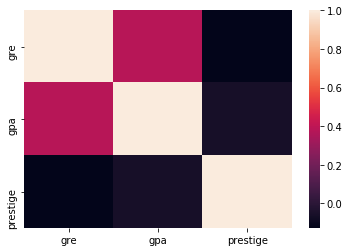

In [9]:
import seaborn as sns
%matplotlib inline
f=sns.heatmap(data_fill[['gre','gpa','prestige']].corr())

##### How to rescale data
Both of GPA and GRE scores have marginal outliers. Also, GRE score has a much larger magnitude of scale than GPA score  and it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. To scaling the entire sample and shrinking the distance between outliers and inliers, I will use QuantileTransformer to scale the data. 

In [10]:
from sklearn.preprocessing import QuantileTransformer
X_scores = data_fill[['gre','gpa']]
X_scale =QuantileTransformer(output_distribution='normal').fit_transform(X_scores)
X_scale = pd.DataFrame(X_scale, columns=['gre','gpa'])
data_new=data_fill[['admit','prestige']].join(X_scale.loc[:,:])
data_new.head()

,admit,prestige,gre,gpa
0,0,3.0,-1.761948,0.523537
1,1,3.0,0.592444,0.684763
2,1,1.0,5.199338,5.199338
3,1,4.0,0.430727,-0.493553
4,0,4.0,-0.599937,-1.161976


##### How to dummify categorical predictor - prestige

In [12]:
dummies = pd.get_dummies(data_new['prestige'], prefix='prestige')
df = data_new.join(dummies.loc[:,:])
features = ['gre','gpa']+list(dummies.columns)
df.head()

,admit,prestige,gre,gpa,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,3.0,-1.761948,0.523537,0,0,1,0
1,1,3.0,0.592444,0.684763,0,0,1,0
2,1,1.0,5.199338,5.199338,1,0,0,0
3,1,4.0,0.430727,-0.493553,0,0,0,1
4,0,4.0,-0.599937,-1.161976,0,0,0,1


When modeling the class variables - prestige, I dropped prestige_1.0 because it can be determined by another three. Removing one class variable among total four class variables can avoid multicollinearity. The removed variable can be the base category against which other categories can be compared. 

### Part 3 - Demo: Provide a table that explains the data by admission status

In [11]:
df[features].groupby(df['admit']).agg({'gre':['mean','std'],'gpa':['mean','std'],'prestige_1.0': ['sum'],
                                       'prestige_2.0': ['sum'],'prestige_3.0': ['sum'],'prestige_4.0': ['sum']}).T

admit                      0          1
gre          mean   0.035965   0.539418
             std    1.506576   1.642140
gpa          mean   0.050610   0.594793
             std    1.527127   1.760732
prestige_1.0 sum   28.000000  34.000000
prestige_2.0 sum   97.000000  53.000000
prestige_3.0 sum   93.000000  28.000000
prestige_4.0 sum   55.000000  12.000000

The frequency for each prestige by admission status:

| Not Admitted | Admitted
---| ---|---
Prestige 1 | 45 (%) | 54 (%)
Prestige 2 | 64 (%) | 35 (%)
Prestige 3 | 77 (%) | 23 (%)
Prestige 4 | 82 (%) | 18 (%)

### Part 4-  Methods: Write up the methods used in your analysis

1) Logistic Regression as main model is applied to get probabilities and odds of being admitted to graduate school for each factor holding other factors constant. To evaluate the classifier, a new dataset is created with logical combinations of input values to see how the predicted probability of admission changes across different predictors.
Statsmodel and sklearn modules are both applied to compare results. 

2) Another three Classifier models (K-nearest neighbors, Random Forests and AdaBoost) are applied to compare predict results and evaluate modeling qualities. 

### Part 5 - Results: Write up your results

1) From the results of the Logistic Regression model, GPA score with one unit increase is expected to increase 16% of the odds of being admitted to the graduate school holding other variables constant; GRE score with one unit increase is expected to increase 12% of the odds. However these results are not seen statistically significant with low p values. From the below probability plots, it is seen that the influence of GPA scores and GRE scores on the odds of admission to graduate school is affected by different prestige of undergraduate schools. 

![title](image1-result.png)

![title](image2-odds.png)

2) The class variable - Prestige is seen to have a statistically significant influence on the probability of being admitted to graduate school. The odds of being admitted decline as the college rank decreases from tier 1 to tier 4 holding gre and gpa constant. When we use the created and enumberated dataset to predict admission probabilities, as below as seen, with the same gre and gpa score, the probability of being admitted is the highest for students who attended tier 1 college and declines as the college ranks goes down to tier 4. 

When comparing stats model and sklearn, the model coefficients and odds are the same. But the predicted probabilities of admission on the same enumberated dataset are slightly different. 

- Results from statsmodel

![title](image3-predictstats.png)

- Results from sklearn

![title](image3-predictsk.png)

![title](image3.png)

![title](image4.png)

3) The predict results support our initial hypothesis. However, the prediction power looks not strong. The accuracy rate is only 68% close to baseline. Precision and recall rates are both low. 

![title](image5-scoresk.png)

4) To try to increase prediction power, another three models are tested but the accuracy scores keep the level of 65%-69%

- K-nearest neighbors: 
After splitting the dataset into training set, cross-validation set and test set, k is optimized as parameter into K-neighbors Classifier. The cross validation score is 65%. 
The predicted admission results are seen having errors compared to actual admissions. 

![title](image6-kresults.png)

- AdaBoost Classifier: 
As shown as below, the accuracy score keeps 69% regardless of number of trees trained. 

![title](image7-adascore.png)

- Random Forests Classifier:
The highest accuracy rate 69% is generated from training one tree. 

![title](image7-rfscore.png)

Random Forests model cannot interpret how predictors impact the classification - admitted or not, but can tell us what predictors are important. The features are ranked by importance from the model as shown as below. The order is aligned up with the predictor coefficients from Logistic Regression model. When GPA and GRE are rescaled and follow the same Gaussian distribution, GPA score is expected to have higher impact on admission decision than GRE score. 

![title](image8-featurebar.png)

### Discussion: Write up your discussion and future steps

1) As stated in results session and visual charts, gpa and gre scores are positively associated with the probability of being admitted but the association is not statistically significant. The odds of these two factors are affected by college rankings. So future steps could be splitting dataset by prestige and testing association levels between scores and admission for each prestige. 
2) The classifier prediction is not strong for all of applied models. It might due to a) data sample size (400 observations) is small; b) predictors are too limited just three input variables. To increase prediction power, more data points should be colleted and other related factors should be added into model to test such as study majors, genders, nationalities and other input that is required to submit in the university application process. 